In [3]:
import torch

from sbi.analysis import check_sbc, run_sbc, get_nltp, sbc_rank_plot
from sbi.inference import SNPE, SNPE_C, prepare_for_sbi, simulate_for_sbi

from dataloader import *
from utility import *
from models import *

from sbi.utils.get_nn_models import (
    posterior_nn,
)  # For SNPE: posterior_nn(), SNLE: likelihood_nn(). For SNRE: classifier_nn()

from sbi import utils


CUDA is available:  True


In [12]:
# transform data to torch format
convert_to_torch(path="./data_sbc/", prefix="simrun", check_for_nan=True, debug=False, remove_zeros=True, redshift_cutoff=600, statistics=False)

on 0: /home/potato/Documents/projects/master/21cm-sbi/utility.py:105: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
        img = torch.as_tensor(f['lightcones']['brightness_temp'], dtype=torch.float32)
/home/potato/Documents/projects/master/ml-env/lib/python3.11/site-packages/py21cmfast/inputs.py:515: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
        warnings.warn(


|████████████████████████████████████████| 497/497 [100%] in 58.9s (8.43/s)     
Done, 0 NaNs encountered in 
[]


In [13]:
norm_range = torch.tensor([
            [0.3,10.0], # M_WDM
            [0.2,0.4], # OMm
            [38, 42], # L_X
            [100, 1500], # NU_X_THRESH
            [4, 5.3], # ION_Tvir_MIN
            [10.0, 250.0], # HII_EFF_FACTOR
], dtype = torch.float32)

data_train = DataHandler(path="./data/", prefix="batch", load_to_ram=False,
                         split = 1, training_data = True,
                         apply_norm=True, norm_range=norm_range, augmentation_probability=0)

dataloader_train = DataLoader(data_train, batch_size=8, shuffle=True,
                              num_workers = 2, pin_memory = True, prefetch_factor=2)

data_sbc = DataHandler(path="./data_sbc/", prefix="batch", load_to_ram=False,
                         split = 1, training_data = True,
                         apply_norm=True, norm_range=norm_range, augmentation_probability=0)
dataloader_sbc = DataLoader(data_sbc, batch_size=8, shuffle=True,
                              num_workers = 2, pin_memory = True, prefetch_factor=2)

model = ModelHandler(Model = Summary_net_lc_smol, device='cpu')
model.load_model("./summary_net.pt")

### SNPE ###

# define the maf
density_estimator_build_fun = posterior_nn(
    model="maf", hidden_features=60, num_transforms=6
)

prior = utils.BoxUniform(low=torch.zeros((6)), high=torch.ones((6)))

# do inference using a freezed summary model
x,y = model.full_inference(dataloader_train)

# train the maf
inference = SNPE(prior=prior, density_estimator=density_estimator_build_fun)
inference.append_simulations(y,x)
density_estimator = inference.train()

posterior = inference.build_posterior(density_estimator, prior=prior)

# do inference using a freezed summary model
x,y = model.full_inference(dataloader_sbc)

# run SBC: for each inference we draw 1000 posterior samples.
num_posterior_samples = 1000
ranks, dap_samples = run_sbc(
    y, x, posterior, num_posterior_samples=num_posterior_samples
)
check_stats = check_sbc(
    ranks, y, dap_samples, num_posterior_samples=num_posterior_samples
)

print(
    f"kolmogorov-smirnov p-values \ncheck_stats['ks_pvals'] = {check_stats['ks_pvals'].numpy()}"
)
print(
    f"c2st accuracies \ncheck_stats['c2st_ranks'] = {check_stats['c2st_ranks'].numpy()}"
)
print(f"- c2st accuracies check_stats['c2st_dap'] = {check_stats['c2st_dap'].numpy()}")

|                                        | ▁▃▅ 0/72 [0%] in 0s (~0s, 0.0/s) 

|████████████████████████████████████████| 72/72 [100%] in 4.3s (16.95/s)       
|████████████████████████████████████████| 63/63 [100%] in 3.6s (17.49/s)       


/home/potato/Documents/projects/master/ml-env/lib/python3.11/site-packages/sbi/analysis/sbc.py:57: UserWarning: Number of SBC samples should be on the order of 100s to give realiable
            results. We recommend using 300.
  warnings.warn(
Running 497 sbc samples.: 100%|██████████| 497/497 [00:18<00:00, 26.49it/s]
/home/potato/Documents/projects/master/ml-env/lib/python3.11/site-packages/sbi/analysis/sbc.py:363: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  if (c2st_scores.std(0) > 0.05).any():


kolmogorov-smirnov p-values 
check_stats['ks_pvals'] = [1.2127642e-09 0.0000000e+00 4.8413897e-18 0.0000000e+00 5.0446745e-44
 0.0000000e+00]
c2st accuracies 
check_stats['c2st_ranks'] = [0.56433177 0.6428557  0.54423124 0.65389067 0.61770976 0.63480026]
- c2st accuracies check_stats['c2st_dap'] = [0.563342   0.52314603 0.48896503 0.56541294 0.4929496  0.5261053 ]


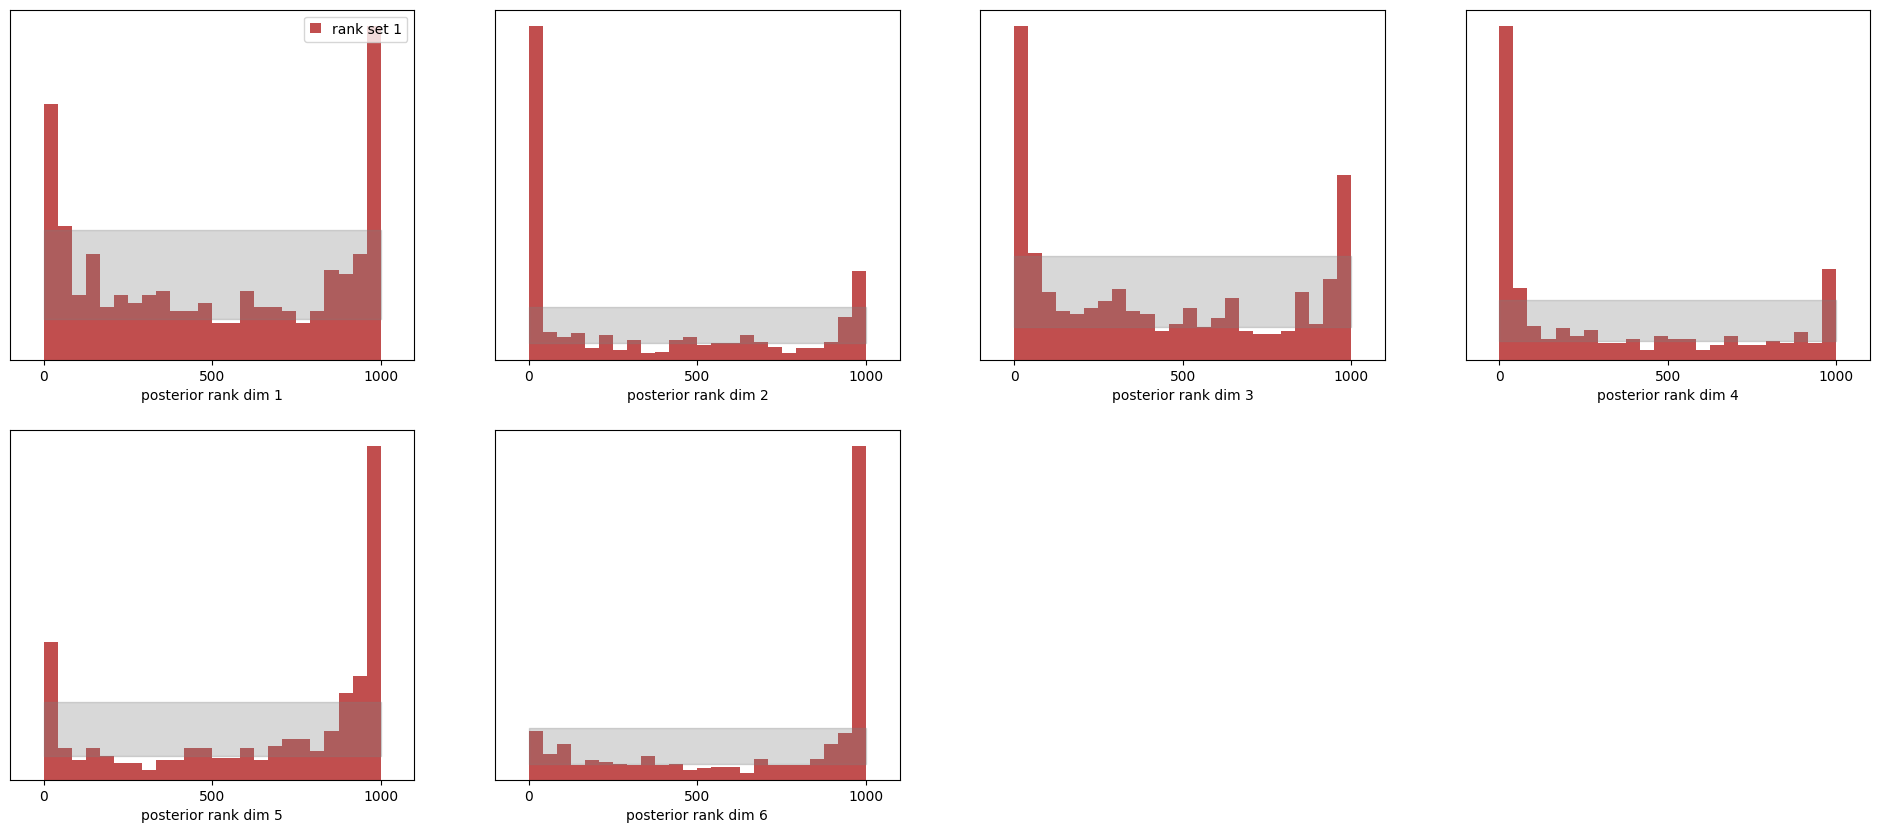

In [14]:
f, ax = sbc_rank_plot(
    ranks=ranks,
    num_posterior_samples=num_posterior_samples,
    plot_type="hist",
    num_bins=None,  # by passing None we use a heuristic for the number of bins.
)

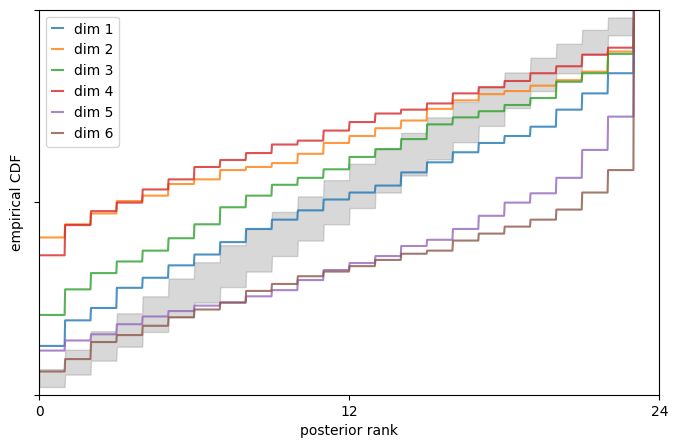

In [15]:
f, ax = sbc_rank_plot(ranks, 1_000, plot_type="cdf")

In [4]:
(0,1)

(0, 1)